# Toy model 

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
sns.set_style('whitegrid')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

sns.set_palette('colorblind')

from src.datagen import create_X, get_train_val_test, TumorGrowth
from src.models import SigLasso, GRUModel, NeuralCDE
from src.sampling import downsample
from src.utils import get_cumulative_moving_sum, fill_forward, l2_distance, mse_on_grid, normalize_path
from src.train import train_gru, train_neural_cde


This notebook displays a short illustration of our method on a toy model. 

# Generate and downsample data

We first generate some data according to a well-specified CDE model. 

In [83]:
model_X = 'cubic'
model_Y = 'cde'

n_points_true = 1000

dim_X = 4
dim_Y = 1
non_linearity_Y = 'Sigmoid'

n_train = n_test = n_val = 300

In [107]:
X_raw_train, Y_raw_train, X_raw_val, Y_raw_val, X_raw_test, Y_raw_test = get_train_val_test(model_X = model_X,
                                                                                           model_Y = model_Y,
                                                                                           dim_X=dim_X, 
                                                                                           dim_Y = dim_Y, 
                                                                                           n_train = n_train,
                                                                                           n_val = n_val,
                                                                                           n_test = n_test,
                                                                                           n_points_true = n_points_true,
                                                                                           non_linearity_Y='Tanh')

Let us plot our feature paths for a few different individuals. 

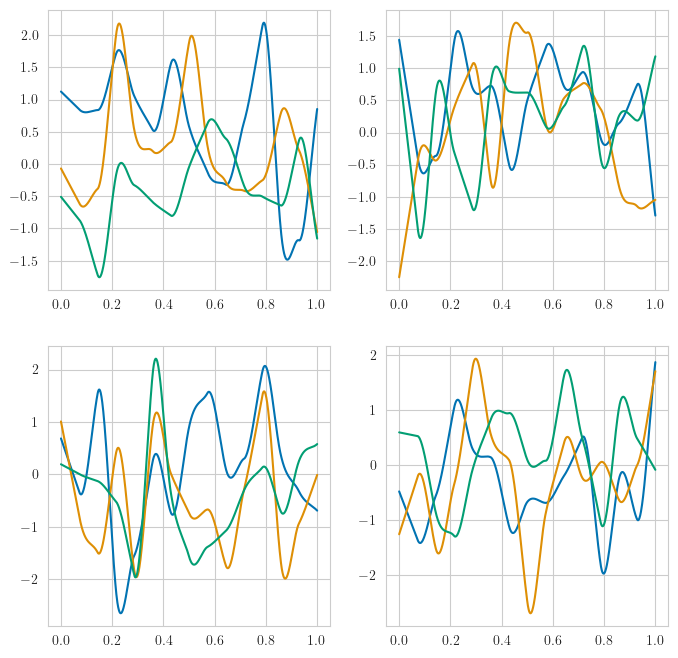

In [108]:
f,ax= plt.subplots(2,2,figsize=(8,8))
for i in np.arange(4):
    ax[i//2,i%2].plot(X_raw_train[i,:,0],X_raw_train[i,:,1:])

We now plot the target for the same individuals. 

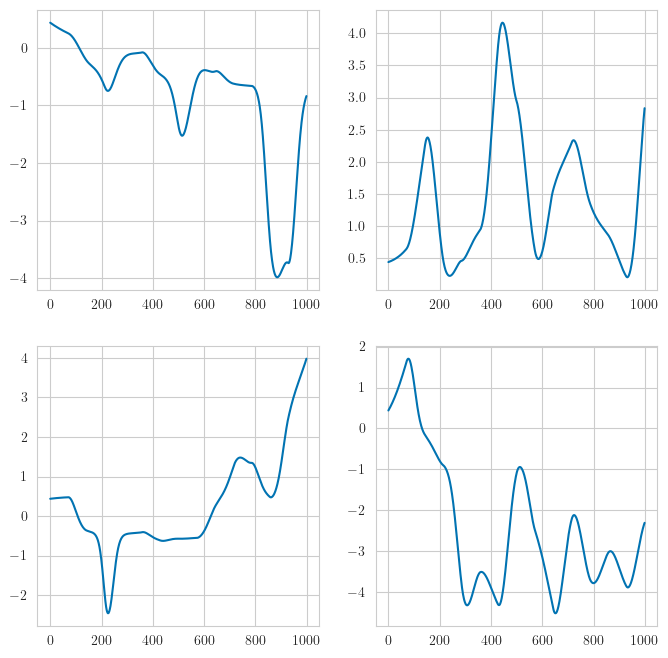

In [109]:
f,ax= plt.subplots(2,2,figsize=(8,8))
for i in np.arange(4):
    ax[i//2,i%2].plot(Y_raw_train[i,:,:])

We now downsample the data.

In [110]:
n_points_Y = 4
n_points_X = 10

In [111]:
X_train, grid_X_train = downsample(
        X_raw_train, n_points_X, keep_first=True, keep_last=True)
Y_train, grid_Y_train = downsample(
        Y_raw_train, n_points_Y, keep_first=False, keep_last=True,
        on_grid=grid_X_train)

X_val, grid_X_val = downsample(
        X_raw_val, n_points_X, keep_first=True, keep_last=True)
Y_val, grid_Y_val = downsample(
        Y_raw_val, n_points_Y, keep_first=False, keep_last=True,
        on_grid=grid_X_val)

In [112]:
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

X_train shape: torch.Size([300, 12, 4])
Y_train shape: torch.Size([300, 5, 1])


This is what the downsampled data looks like. 

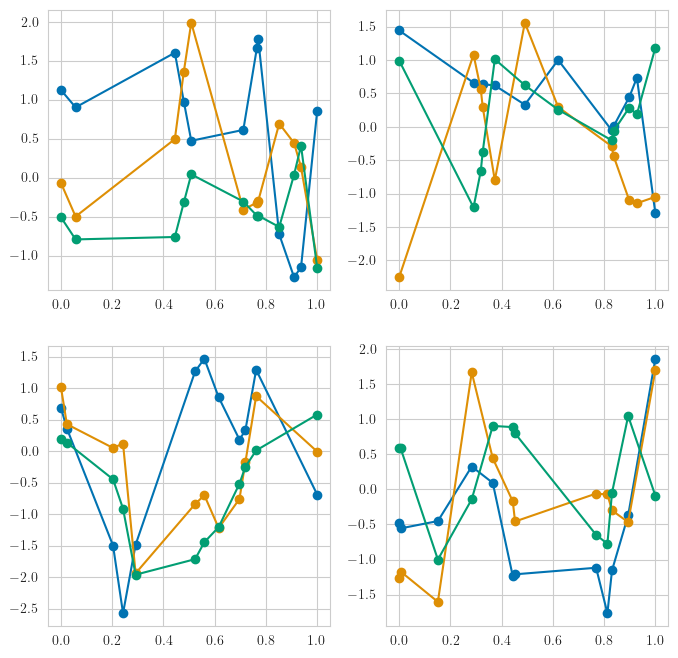

In [113]:
f,ax= plt.subplots(2,2,figsize=(8,8))
for i in np.arange(4):
    ax[i//2,i%2].plot(X_train[i,:,0],X_train[i,:,1:],marker='o')

# Model 1:  SigLasso

In [123]:
sig_order = 3

lasso_sig = SigLasso(sig_order, Y_train.shape[2], weighted=True, normalize=False)
lasso_sig.train(X_train, Y_train, grid_Y=grid_Y_train, grid_X=grid_X_train)

In [124]:
Y_train_pred = lasso_sig.predict(X_raw_train[:10,:,:])
Y_test_pred = lasso_sig.predict(X_raw_test[:10,:,:])

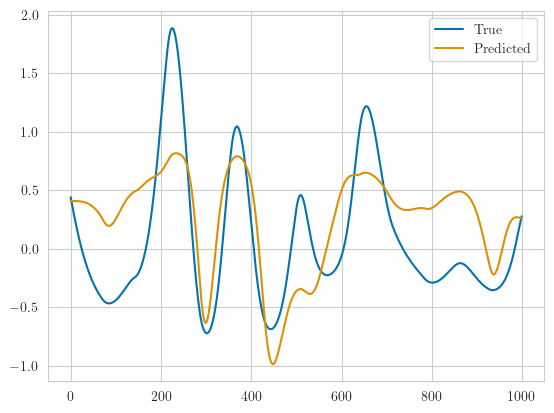

In [130]:
i = 6

plt.plot(np.arange(Y_raw_train.shape[1] ), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()

# Model 2 : Neural CDE

In [133]:
n_epochs = 100
ncde_vector_field = 'almost_original'
ncde_lr = 1e-5

ncde_model = NeuralCDE(X_train.shape[2], Y_train.shape[2], vector_field=ncde_vector_field)

train_neural_cde(ncde_model, X_train, Y_train, n_epochs, grid_Y=grid_Y_train, lr=ncde_lr)

Epoch: 0   Training loss: 6.661436557769775
Epoch: 1   Training loss: 6.638911247253418
Epoch: 2   Training loss: 6.615824222564697
Epoch: 3   Training loss: 6.592233180999756
Epoch: 4   Training loss: 6.568084239959717
Epoch: 5   Training loss: 6.5433349609375
Epoch: 6   Training loss: 6.518149375915527
Epoch: 7   Training loss: 6.4928364753723145
Epoch: 8   Training loss: 6.46787166595459
Epoch: 9   Training loss: 6.443362236022949
Epoch: 10   Training loss: 6.419251441955566
Epoch: 11   Training loss: 6.395450115203857
Epoch: 12   Training loss: 6.371987819671631
Epoch: 13   Training loss: 6.349071025848389
Epoch: 14   Training loss: 6.326938629150391
Epoch: 15   Training loss: 6.305802345275879
Epoch: 16   Training loss: 6.285804271697998
Epoch: 17   Training loss: 6.267005443572998
Epoch: 18   Training loss: 6.249271392822266
Epoch: 19   Training loss: 6.232943058013916
Epoch: 20   Training loss: 6.218395233154297
Epoch: 21   Training loss: 6.205997943878174
Epoch: 22   Training l

KeyboardInterrupt: 

In [134]:
Y_test_pred = ncde_model.predict_trajectory(X_raw_test)
Y_train_pred = ncde_model.predict_trajectory(X_raw_train)

In [21]:
print(f'l2_train = ', l2_distance(Y_train_pred, Y_raw_train))
print(f'l2_test = ',l2_distance(Y_test_pred, Y_raw_test))

l2_train =  0.0396234
l2_test =  0.04171416


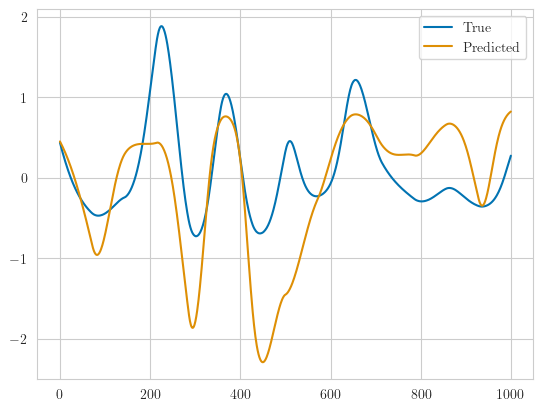

In [135]:
i = 6

plt.plot(np.arange(Y_raw_train.shape[1]), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()

# Model 3 : GRU

In [157]:
gru_hidden_units = 128
gru_lr =1e-05
n_epochs = 100

gru_model = GRUModel(X_train.shape[2], gru_hidden_units, Y_train.shape[2])

train_gru(gru_model, X_train, Y_train, n_epochs, grid_Y=grid_Y_train, lr=gru_lr)

Epoch: 0   Training loss: 7.050395965576172
Epoch: 1   Training loss: 7.045571804046631
Epoch: 2   Training loss: 7.041010856628418
Epoch: 3   Training loss: 7.036672115325928
Epoch: 4   Training loss: 7.032532215118408
Epoch: 5   Training loss: 7.028573513031006
Epoch: 6   Training loss: 7.024778842926025
Epoch: 7   Training loss: 7.021134376525879
Epoch: 8   Training loss: 7.017629146575928
Epoch: 9   Training loss: 7.014251232147217
Epoch: 10   Training loss: 7.010989189147949
Epoch: 11   Training loss: 7.0078349113464355
Epoch: 12   Training loss: 7.0047760009765625
Epoch: 13   Training loss: 7.001803874969482
Epoch: 14   Training loss: 6.9989094734191895
Epoch: 15   Training loss: 6.996083736419678
Epoch: 16   Training loss: 6.993317604064941
Epoch: 17   Training loss: 6.990602970123291
Epoch: 18   Training loss: 6.987928867340088
Epoch: 19   Training loss: 6.985286712646484
Epoch: 20   Training loss: 6.982669353485107
Epoch: 21   Training loss: 6.98006534576416
Epoch: 22   Traini

GRUModel(
  (gru): GRU(4, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [158]:
Y_test_pred = gru_model.predict_trajectory(X_raw_test)
Y_train_pred = gru_model.predict_trajectory(X_raw_train)

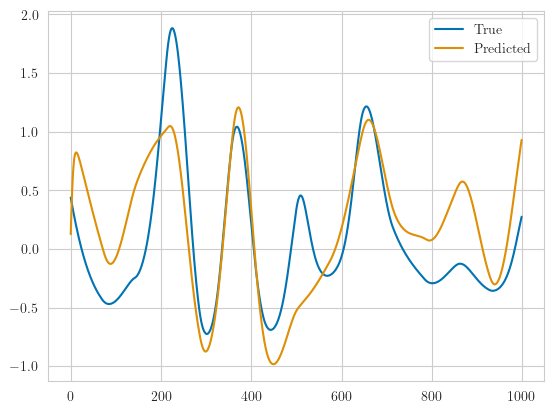

In [159]:
i = 6

plt.plot(np.arange(Y_raw_train.shape[1]), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()